# 1 Цель проекта
### Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

### Вам поставлена задача создать такую модель. 
### Точность на тестовой выборке должна быть меньше MAPE - 13.5%

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

"pip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


# 2 Загрузка данных

In [3]:
# Подгрузим наши данные из соревнования

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_train, df_test], ignore_index = True) # объединяем

In [5]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# 3 Заполнение пропусков и создание вспомогательных признаков
## 3.1 Создание вспомогательных признаков

### На основе адреса отеля создадим вспомогательный признак "city, country", для чего напишем функцию

In [6]:
# Напишем функцию для выделения признака 'city, country' из адреса отеля
def get_city_country(elem):
    str_elem = elem.split(' ')
    if str_elem[-1] == 'Kingdom':
        city_country = str_elem[-5] + ', ' + str_elem[-2] + ' ' + str_elem[-1]
    else:
        city_country = str_elem[-2] + ', ' + str_elem[-1]
    return city_country

### Теперь создадим сам признак, и вместе с ним создадим дополнительно вспомогательный признак "country" и признак, который будем использовать далее для обучения - "city"

In [7]:
hotels['city, country'] = hotels['hotel_address'].apply(get_city_country)
hotels['city'] = hotels['city, country'].apply(lambda x: x.split(', ')[0])
hotels['country'] = hotels['city, country'].apply(lambda x: x.split(', ')[1])

## 3.2 Заполнение пропусков
### Заполним пропуски в "lan" и "lng" координатами самих городов

#### Как показала практика замена на нули, как было изначально, на модели слабо сказывается

In [8]:
import geopy
from geopy.geocoders import Nominatim
# Создаём объект геокодера
geolocator = Nominatim(user_agent="name_of_your_app")


list_cс = list(set(hotels['city, country']))
dict_lat = {}
dict_lng = {}

for elem in list_cс:
    dict_lat[elem] = geolocator.geocode(elem).latitude

for elem in list_cс:
    dict_lng[elem] = geolocator.geocode(elem).longitude

In [9]:
# Создадим вспомогательные признаки
hotels['lat_city'] = hotels['city, country'].apply(lambda x: dict_lat[x])
hotels['lng_city'] = hotels['city, country'].apply(lambda x: dict_lng[x])
# Создадим словарь для замены значений
values = {'lat': hotels['lat_city'], 'lng': hotels['lng_city']}
# Заменим пропуски
hotels = hotels.fillna(values)
# Удалим вспомогательные признаки
hotels = hotels.drop(['lat_city', 'lng_city', 'city, country'], axis=1)

# 4 Преобразование признаков и создание новых
## 4.1 Преобразование количества дней
### Признак 'days_since_review' приведем к целочисленному значению

In [8]:
hotels['days_since_review'] = hotels['days_since_review'].str.split(' ').str[0].astype(int)

## 4.2 Преобразование даты отзыва
### Признак 'review_date' приведем к типу даты и на его основе сформируем новые признаки - квартал, месяц и год

In [9]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['quarter_rew'] = hotels['review_date'].dt.quarter
hotels['month_rew'] = hotels['review_date'].dt.month
hotels['year_rew'] = hotels['review_date'].dt.year
hotels = hotels.drop('review_date', axis=1)

## 4.3 Создадим признак гражданство

In [10]:
hotels['citizen'] = hotels.apply(lambda x: 1 if x['reviewer_nationality'].strip() == x['country'] else 0, axis=1)

## 4.4 Анализ полученных признаков
### Рассмотрим некоторые зависимости на основе новых признаков
### Рассмотрим распределения по городам

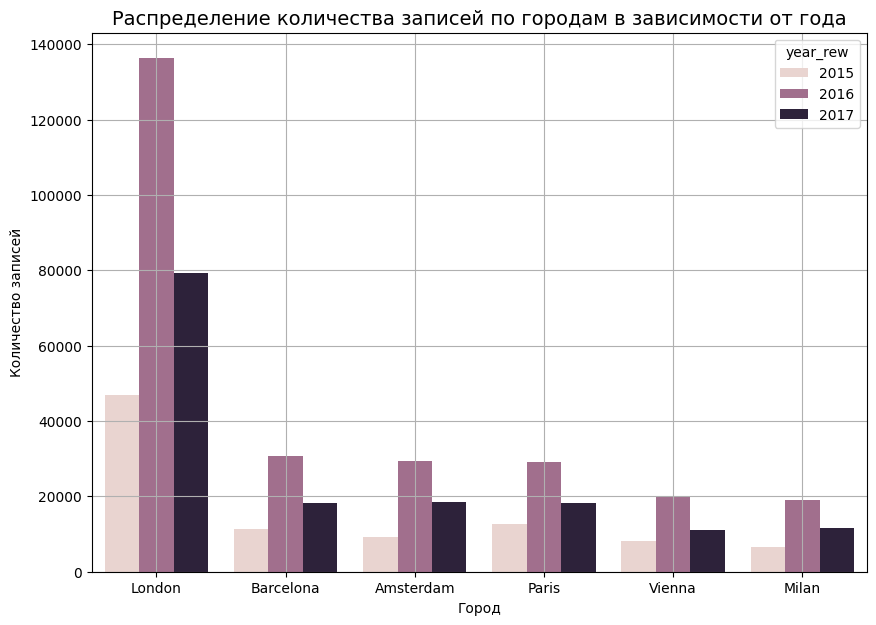

In [17]:
data1 = hotels.value_counts(['city', 'year_rew']).reset_index()
fig = plt.figure(figsize=(10, 7))
axes = sns.barplot(data=data1,
    x='city', 
    y='count', hue='year_rew')
axes.grid()
axes.set_title('Распределение количества записей по городам в зависимости от года', fontsize=14)
axes.set_xlabel('Город')
axes.set_ylabel('Количество записей');
fig = axes.figure
fig.savefig('pic/pic1.png')

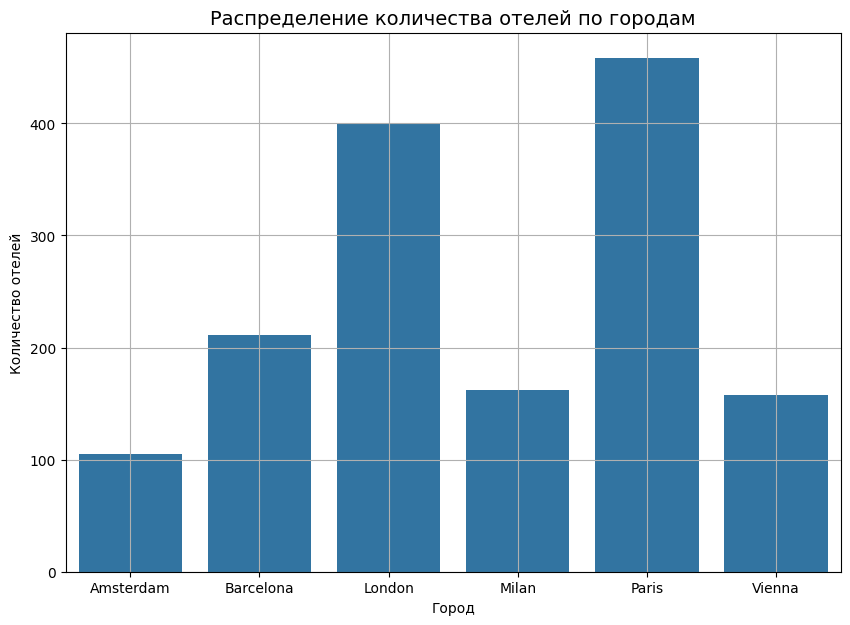

In [18]:
hot_dist = hotels.groupby('city')['hotel_name'].nunique().reset_index()

fig = plt.figure(figsize=(10, 7))
axes = sns.barplot(data=hot_dist,
    x='city', 
    y='hotel_name')
axes.grid()
axes.set_title('Распределение количества отелей по городам', fontsize=14)
axes.set_xlabel('Город')
axes.set_ylabel('Количество отелей');
fig = axes.figure
fig.savefig('pic/pic2.png')

### Выводы: 
1. Наибольшее количество записей приходится на 2016 год
2. Наибольшее количество записей приходится на отели Лондона
3. Наибольшее количество рассматриваемых отелей находятся в Париже

### Рассмотрим распределения оценок отелей

### Для этого возъмем для каждого города два отеля - с наименьшей и наибольше медианой оценки

In [19]:
list_city = list(set(hotels['city']))
list_hotel_sample = []
for elem in list_city:
    cit_hot = hotels[hotels['city'] == elem]
    sc_sit_hot = cit_hot.groupby('hotel_name')['reviewer_score'].median().reset_index()
    sc_sit_hot = sc_sit_hot.sort_values(by='reviewer_score', ignore_index=True)
    n = sc_sit_hot.shape[0] - 1
    list_hotel_sample.append(sc_sit_hot.loc[0, 'hotel_name'])
    list_hotel_sample.append(sc_sit_hot.loc[n, 'hotel_name'])

hotels_sam = hotels[hotels['hotel_name'].isin(list_hotel_sample)]

### Построим гистограммы распределения оценки для каждого полученного отеля. Красной пунктирной линией на графике обозначим медиану оценок отеля

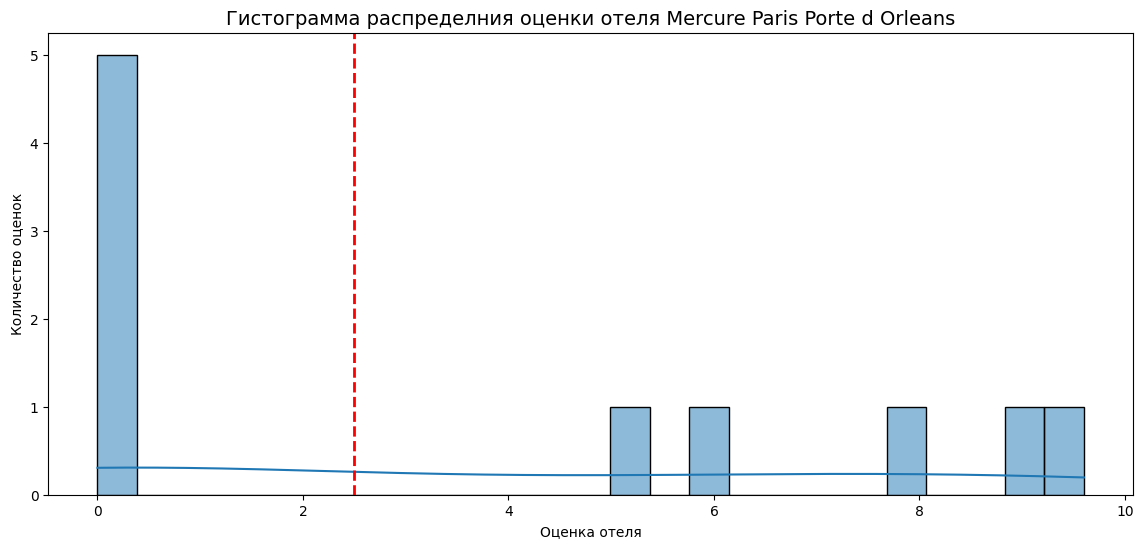

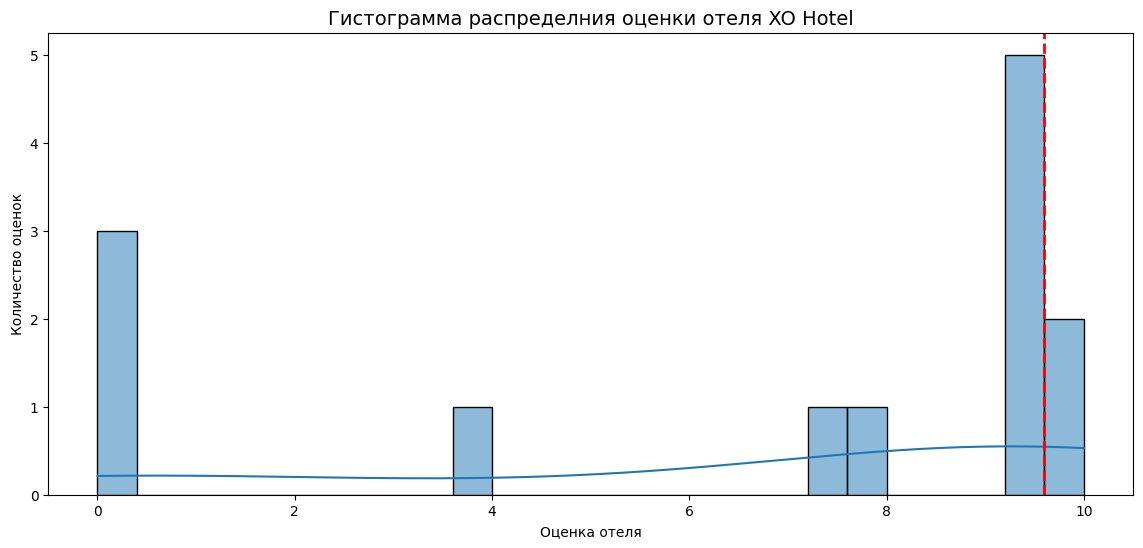

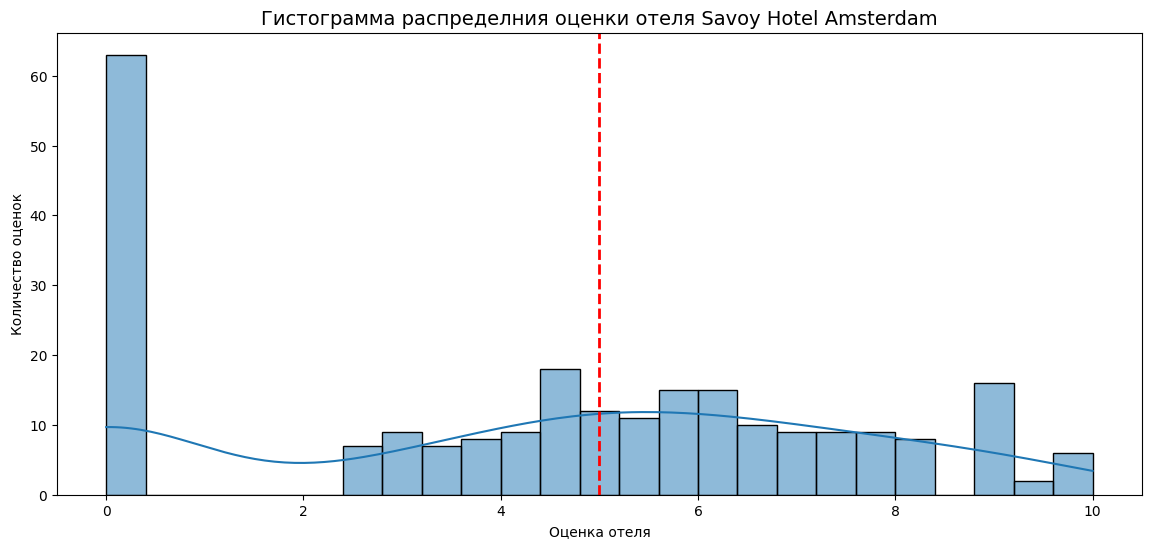

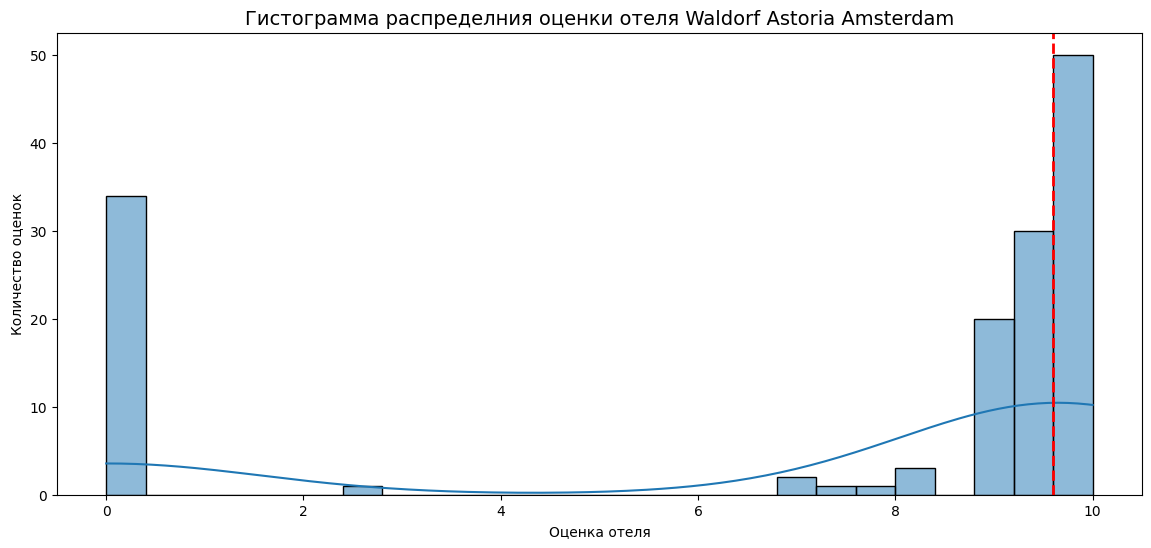

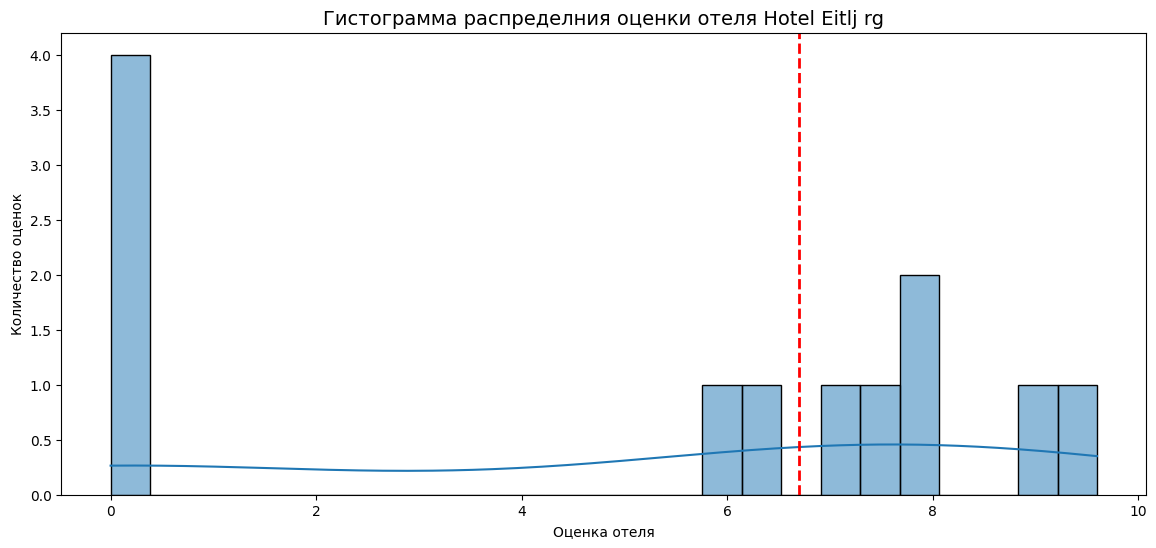

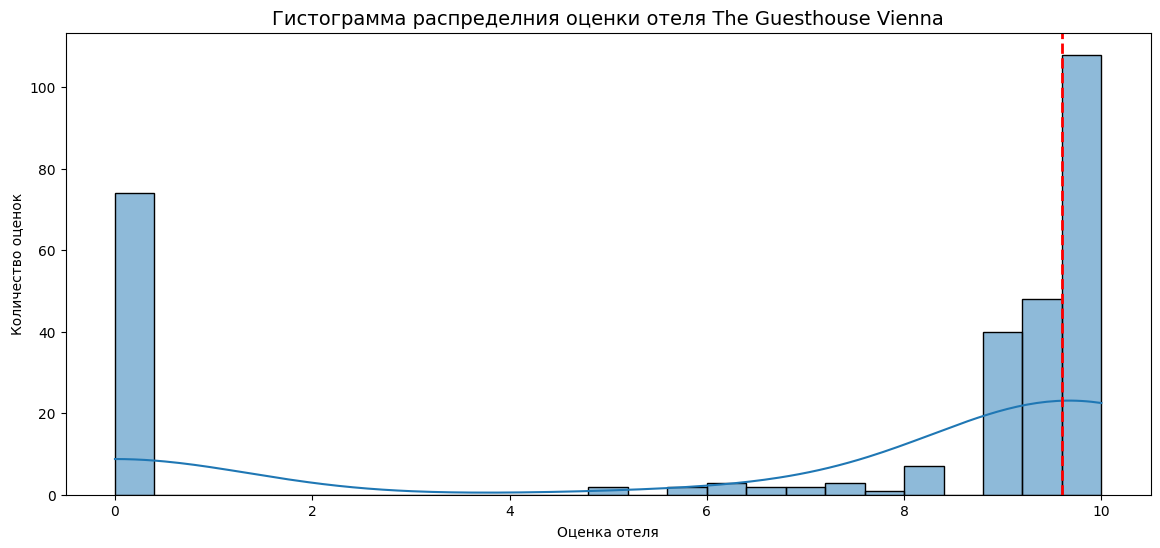

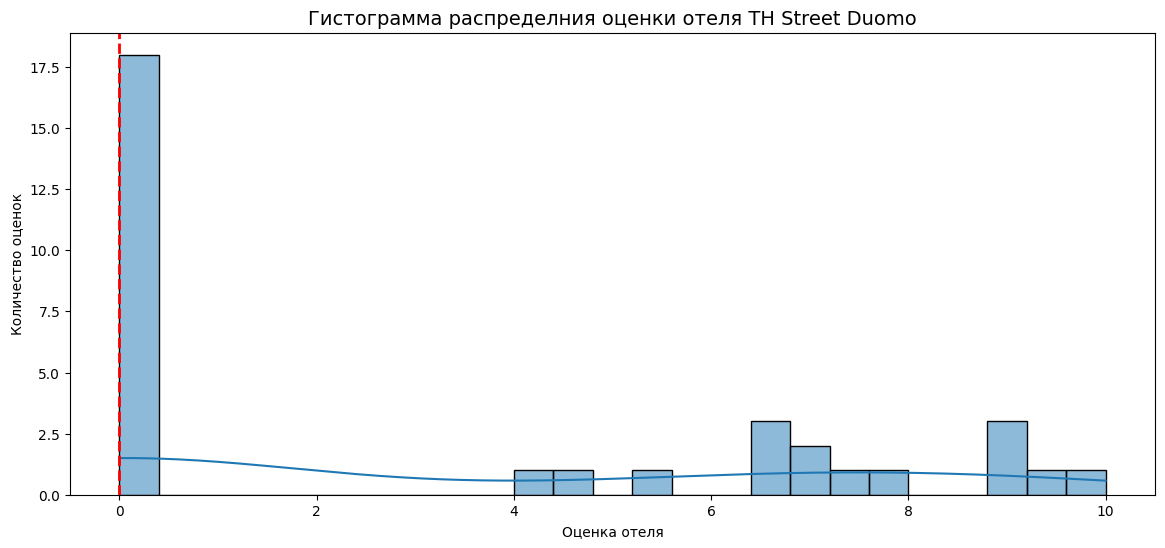

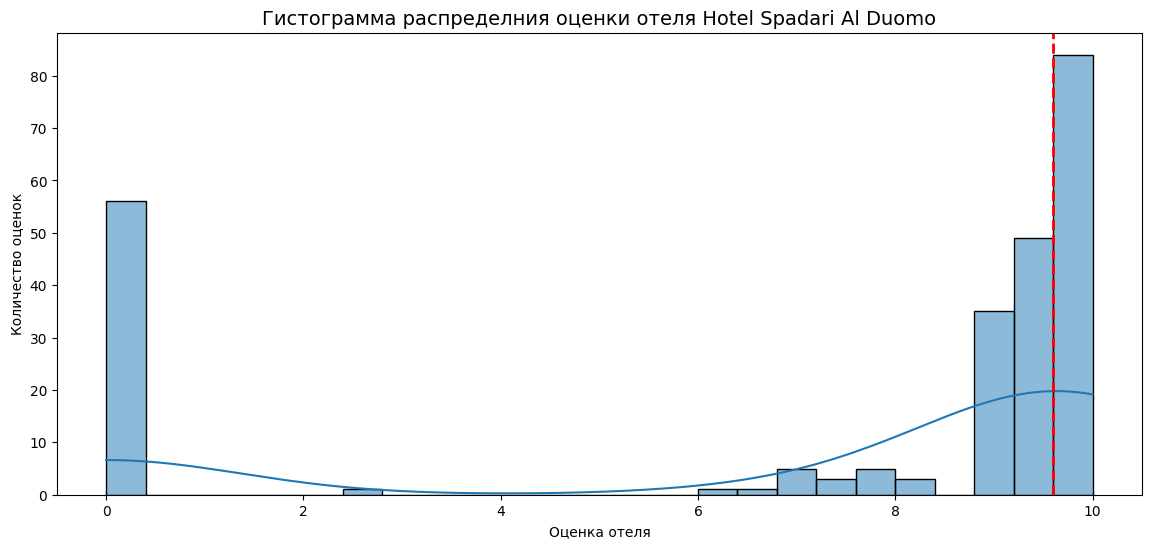

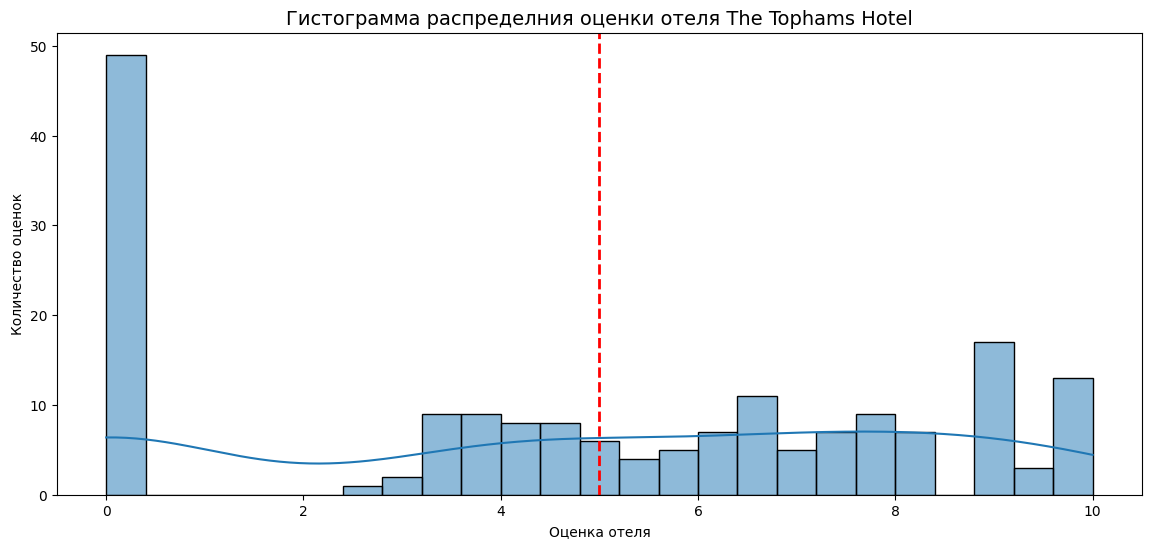

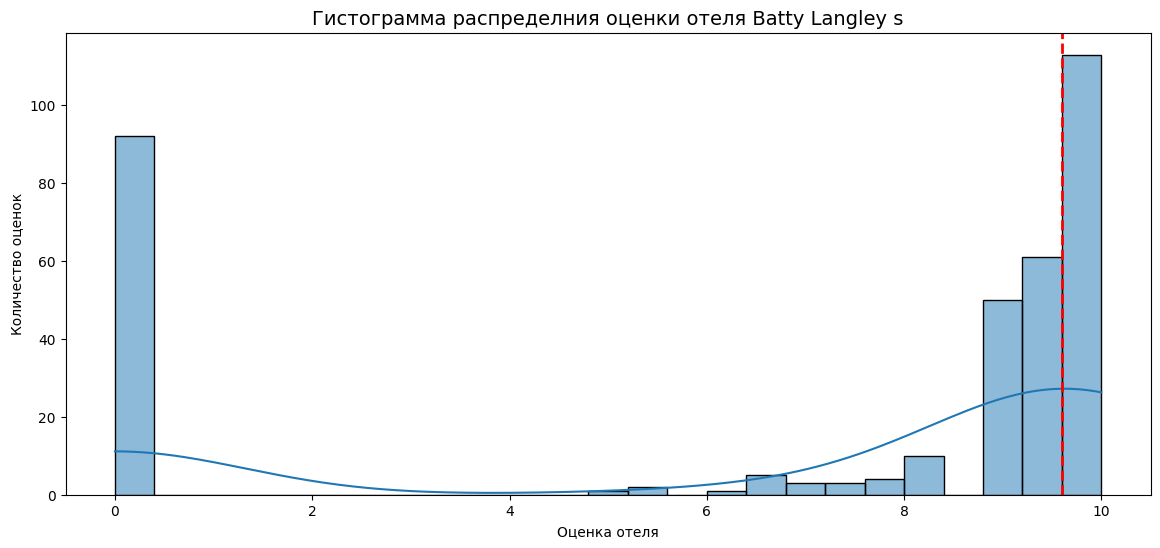

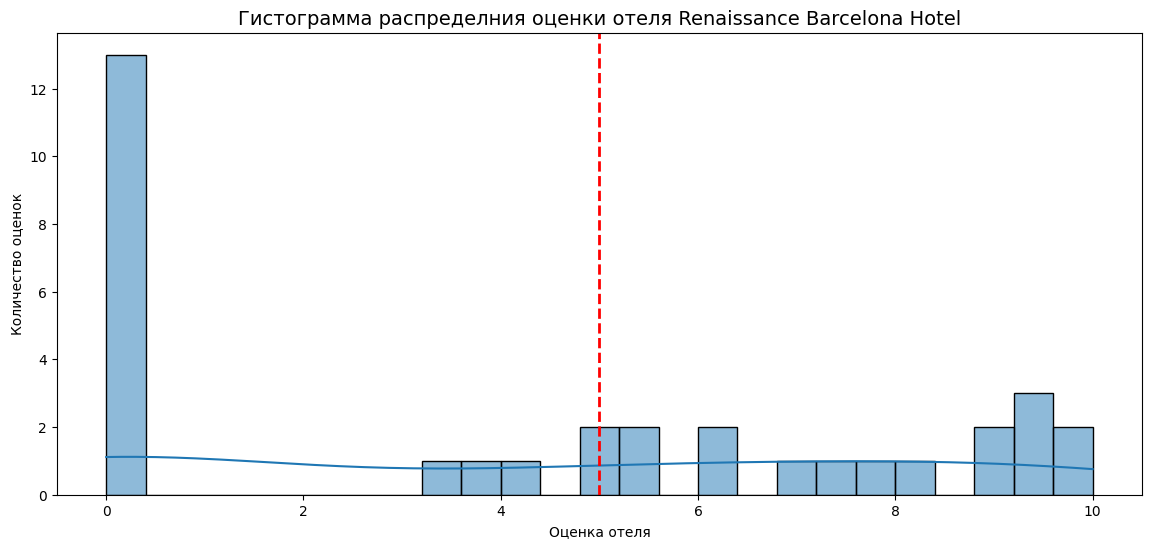

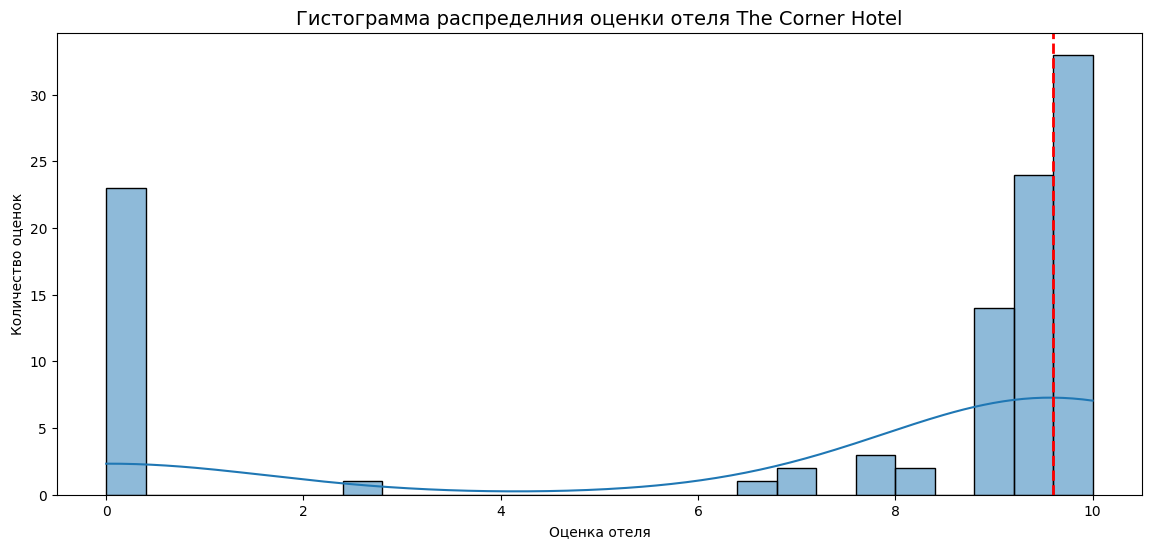

In [20]:
for elem in list_hotel_sample:
    hotels_elem = hotels_sam[hotels_sam['hotel_name'] == elem]
    title = 'Гистограмма распределния оценки отеля ' + elem
    fig = plt.figure(figsize=(14, 6))
    ax = sns.histplot(data=hotels_elem,x='reviewer_score', bins=25, kde=True);
    ax.set_title(title, fontsize=14)
    ax.axvline(hotels_elem['reviewer_score'].median(), color='r', ls='--', lw=2)
    ax.set_xlabel('Оценка отеля')
    ax.set_ylabel('Количество оценок');


### Видно, что все взятые отели имеют ненормальное распределение
### Рассмотрим распределение медианной оценки отелей в зависимости от года и месяца

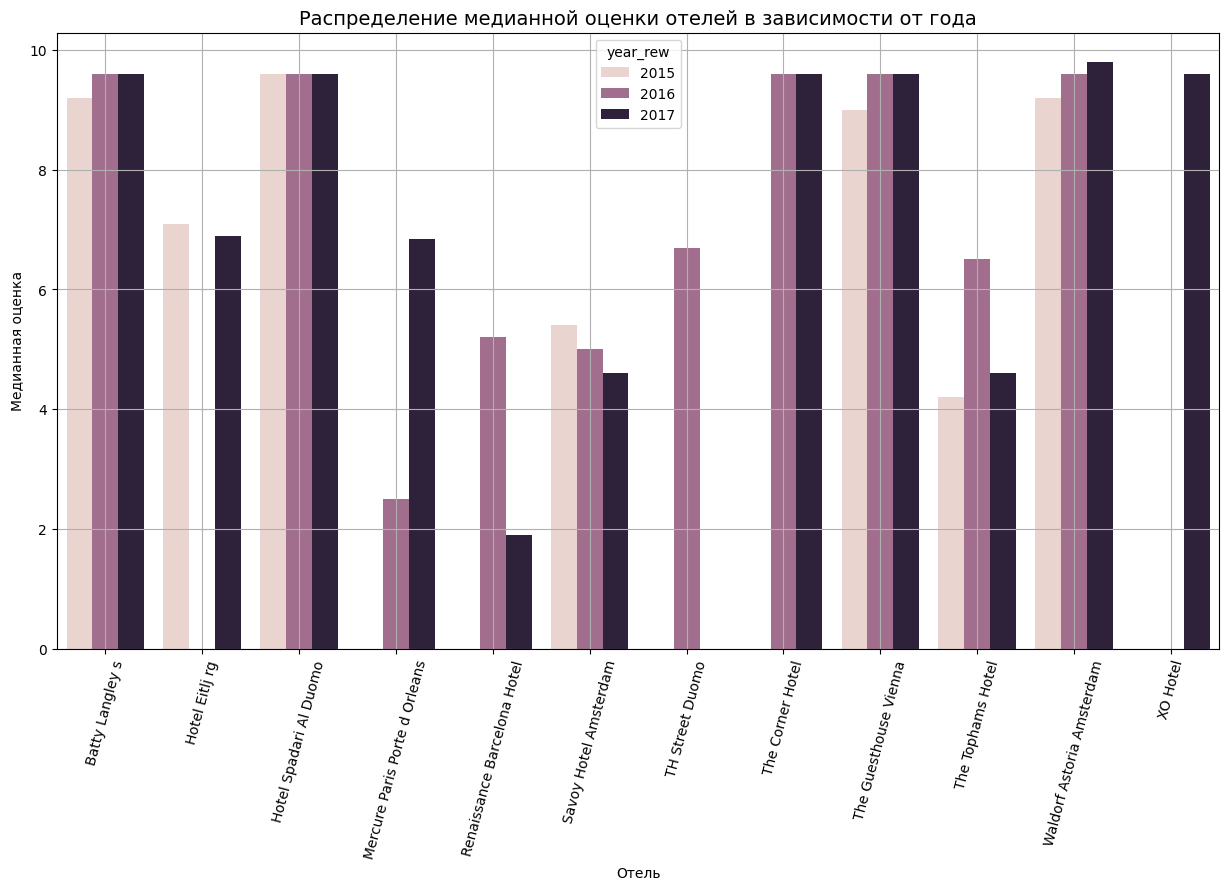

In [21]:
data2 = hotels_sam.groupby(by=['hotel_name', 'year_rew'])['reviewer_score'].median().reset_index()
fig = plt.figure(figsize=(15, 8))
axes = sns.barplot(data=data2,
    x='hotel_name', 
    y='reviewer_score',
    hue='year_rew')
axes.grid()
axes.xaxis.set_tick_params(rotation=75)
axes.set_title('Распределение медианной оценки отелей в зависимости от года', fontsize=14)
axes.set_xlabel('Отель')
axes.set_ylabel('Медианная оценка');

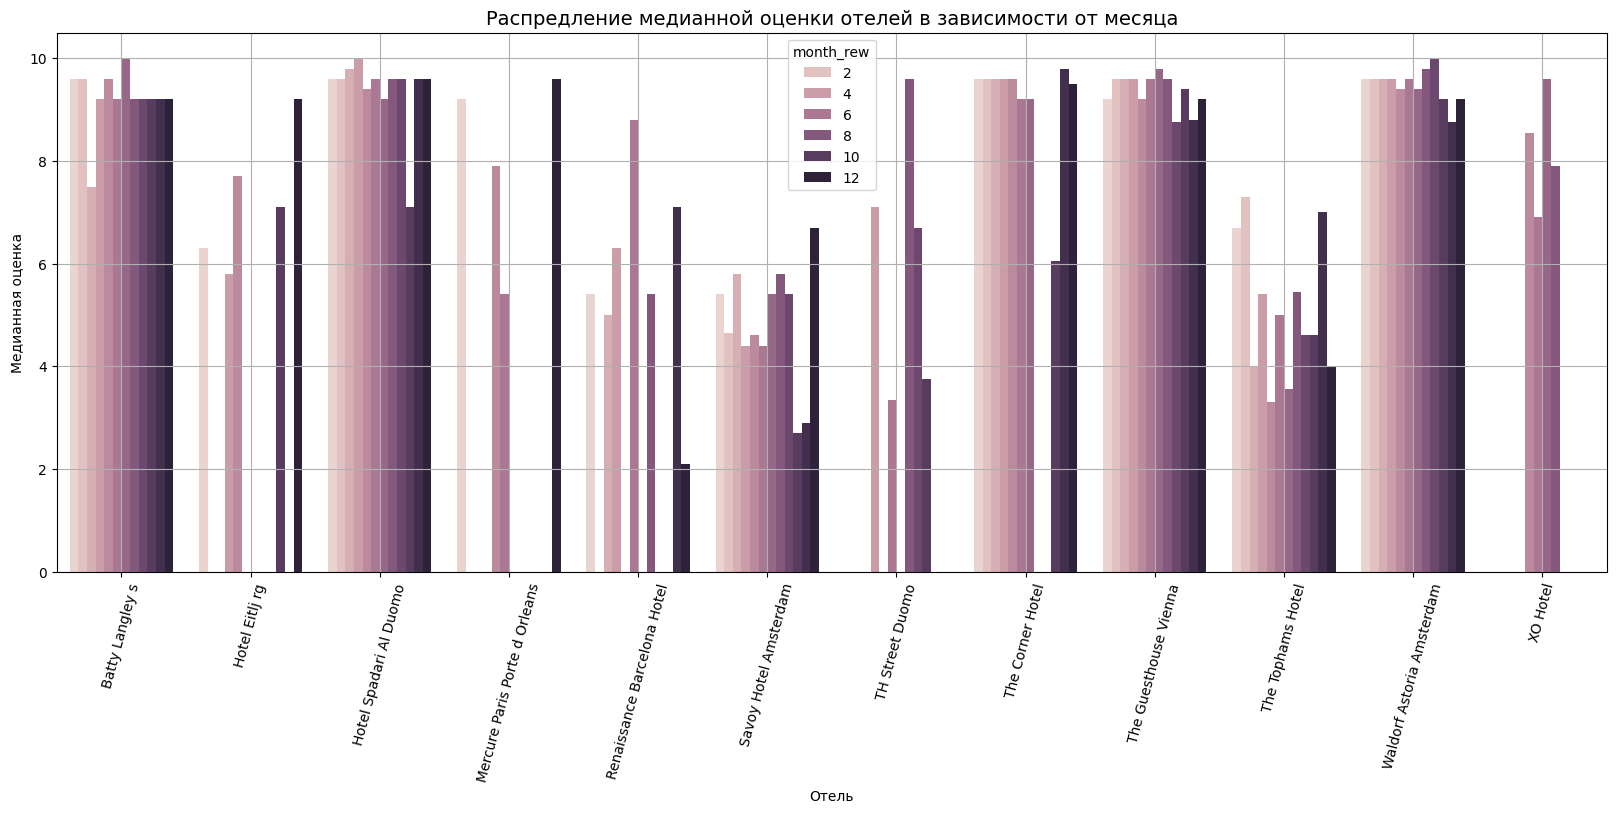

In [22]:
data3 = hotels_sam.groupby(by=['hotel_name', 'month_rew'])['reviewer_score'].median().reset_index()
fig = plt.figure(figsize=(20, 7))
axes = sns.barplot(data=data3,
    x='hotel_name', 
    y='reviewer_score',
    hue='month_rew')
axes.grid()
axes.xaxis.set_tick_params(rotation=75)
axes.set_title('Распредление медианной оценки отелей в зависимости от месяца', fontsize=14)
axes.set_xlabel('Отель')
axes.set_ylabel('Медианная оценка');

### Часть отелей имеет пропуски по годам
### Медианная оценка зависит от месяца и у части отелей есть пропуски по месяцам
### Расмотрим распределение колиства записей для всех отелей от месяца и квартала в зависимости от гражданства посетителя

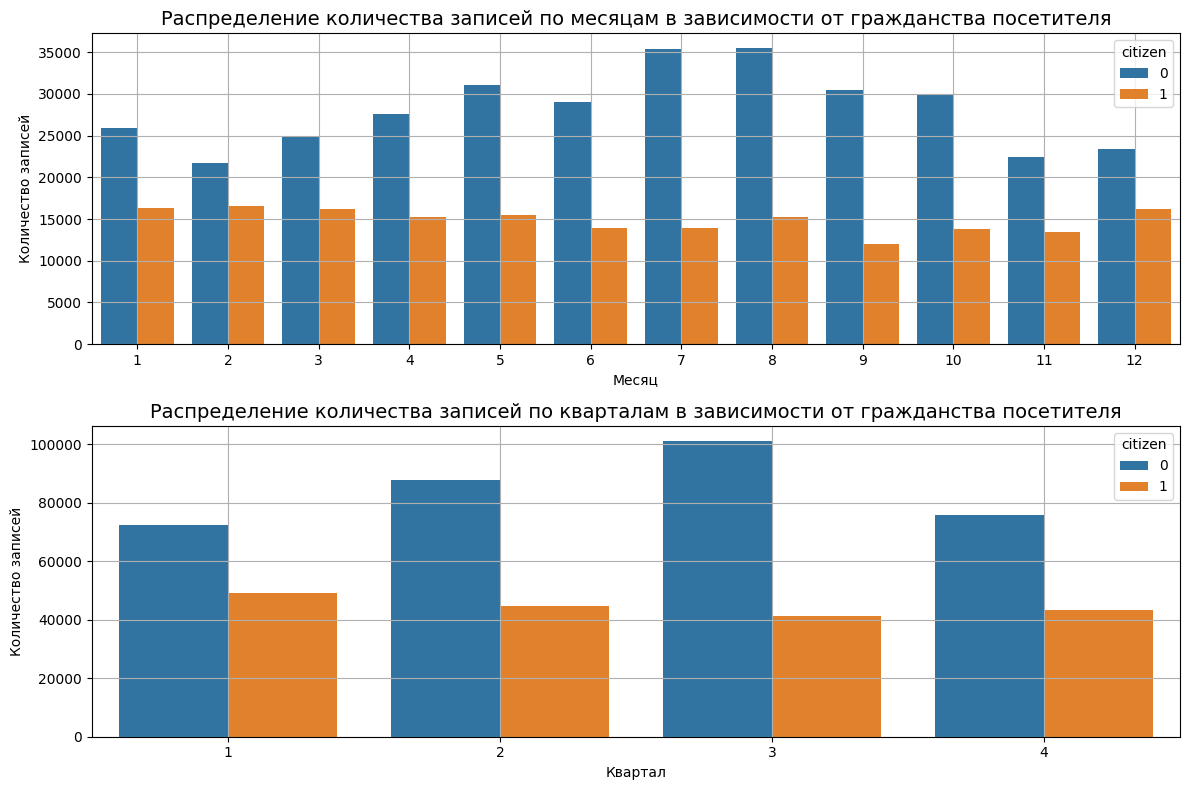

In [23]:
data4 = hotels.value_counts(['month_rew','citizen']).reset_index()
data5 = hotels.value_counts(['quarter_rew','citizen']).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.barplot(data=data4,
    x='month_rew', 
    y='count', hue='citizen', ax=axes[0])
axes[0].grid()
axes[0].set_title('Распределение количества записей по месяцам в зависимости от гражданства посетителя', fontsize=14)
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество записей');
sns.barplot(data=data5,
    x='quarter_rew', 
    y='count', hue='citizen', ax=axes[1])
axes[1].grid()
axes[1].set_title('Распределение количества записей по кварталам в зависимости от гражданства посетителя', fontsize=14)
axes[1].set_xlabel('Квартал')
axes[1].set_ylabel('Количество записей')
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic3.png')
fig = axes[1].figure
fig.savefig('pic/pic4.png')

### Максимум приходится на летние месяцы (3 квартал). При этом наблюдается приток посетителей из других стран и незначительный отток местных жителей

## 4.5 Работа с тегами
### 4.5.1 Тип поездки
### На основе тегов создадим признаки туристической и деловой поездки

In [11]:
def get_leisure_trip(elem):
    list_tag = elem[3: -3].split(" ', ' ")    
    for unit in list_tag:
        list_words = unit.lower().split(' ')        
        if 'leisure' in list_words and 'trip' in list_words:
            return 1     
    return 0

def get_business_trip(elem):
    list_tag = elem[3: -3].split(" ', ' ")    
    for unit in list_tag:
        list_words = unit.lower().split(' ')        
        if 'business' in list_words and 'trip' in list_words:
            return 1     
    return 0

In [12]:
hotels['Leisure_trip'] = hotels['tags'].apply(get_leisure_trip)
hotels['Business_trip'] = hotels['tags'].apply(get_business_trip)


### 4.5.2 Количество тегов
### Создадим признак - количество тегов, описанных посетителем

In [26]:
def get_count_tags(elem):
    list_tag = elem[3: -3].split(" ', ' ")    
    return len(list_tag)

In [27]:
hotels['Count_tags'] = hotels['tags'].apply(get_count_tags)

## 4.6 Анализ полученных признаков
### Рассмотрим ряд зависимостей на основе полученных признаков

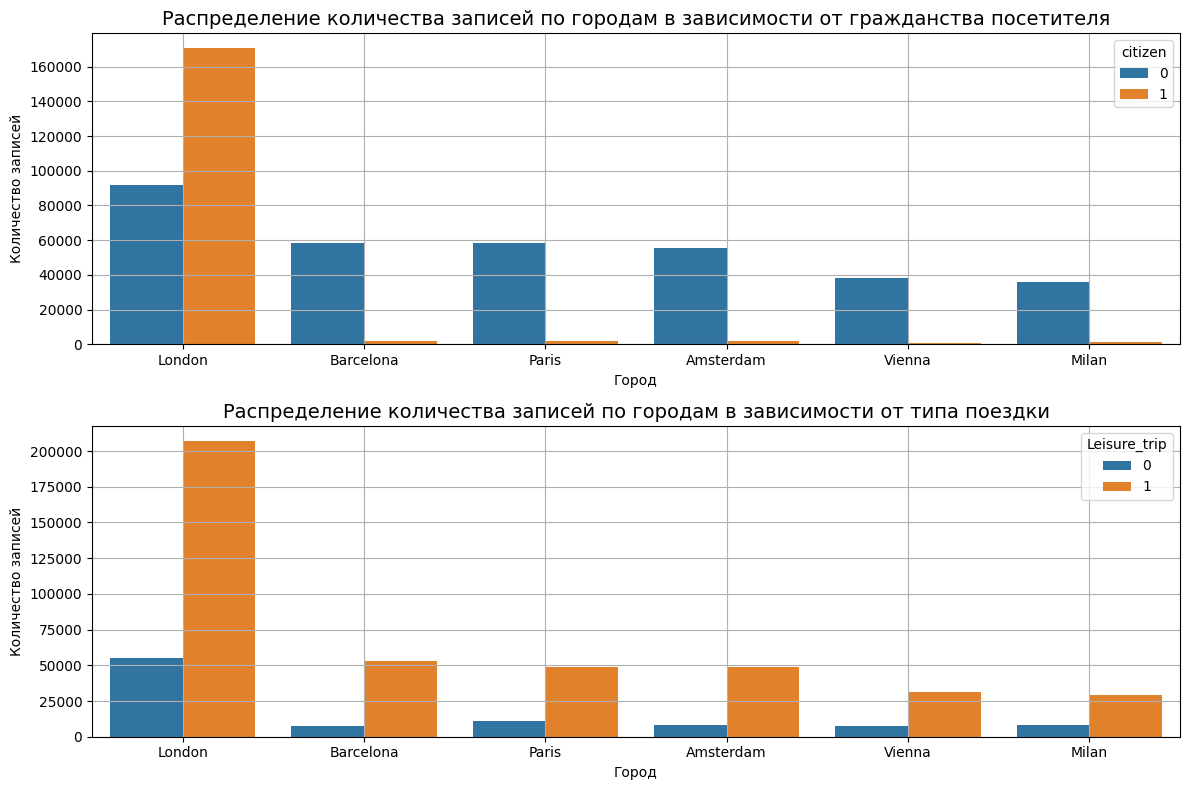

In [28]:
data6 = hotels.value_counts(['city','citizen']).reset_index()
data7 = hotels.value_counts(['city','Leisure_trip']).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
sns.barplot(data=data6,
    x='city', 
    y='count', hue='citizen', ax=axes[0])
axes[0].grid()
axes[0].set_title('Распределение количества записей по городам в зависимости от гражданства посетителя', fontsize=14)
axes[0].set_xlabel('Город')
axes[0].set_ylabel('Количество записей');
sns.barplot(data=data7,
    x='city', 
    y='count', hue='Leisure_trip', ax=axes[1])
axes[1].grid()
axes[1].set_title('Распределение количества записей по городам в зависимости от типа поездки', fontsize=14)
axes[1].set_xlabel('Город')
axes[1].set_ylabel('Количество записей')
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic5.png')
fig = axes[1].figure
fig.savefig('pic/pic6.png')

### Лондон - единственный город, в котором количество местных посетителей превосходит количество приезжих

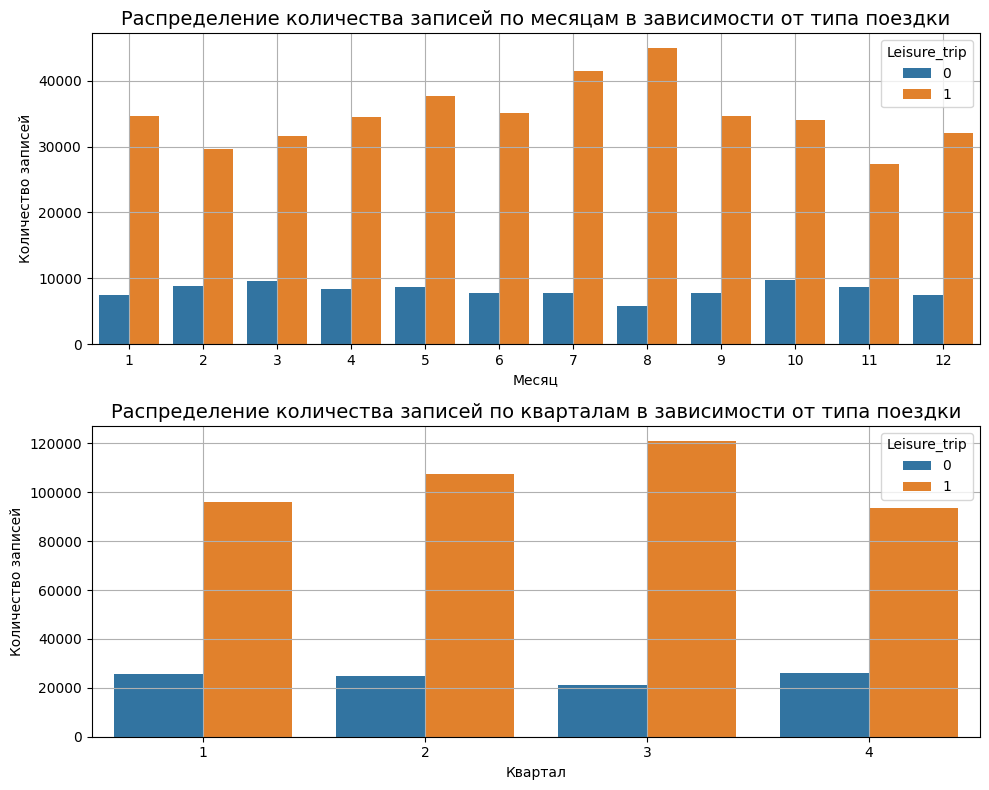

In [29]:
data8 = hotels.value_counts(['month_rew','Leisure_trip']).reset_index()
data9 = hotels.value_counts(['quarter_rew','Leisure_trip']).reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.barplot(data=data8,
    x='month_rew', 
    y='count', hue='Leisure_trip', ax=axes[0])
axes[0].grid()
axes[0].set_title('Распределение количества записей по месяцам в зависимости от типа поездки', fontsize=14)
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество записей');
sns.barplot(data=data9,
    x='quarter_rew', 
    y='count', hue='Leisure_trip', ax=axes[1])
axes[1].grid()
axes[1].set_title('Распределение количества записей по кварталам в зависимости от типа поездки', fontsize=14)
axes[1].set_xlabel('Квартал')
axes[1].set_ylabel('Количество записей')
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic7.png')
fig = axes[1].figure
fig.savefig('pic/pic8.png')

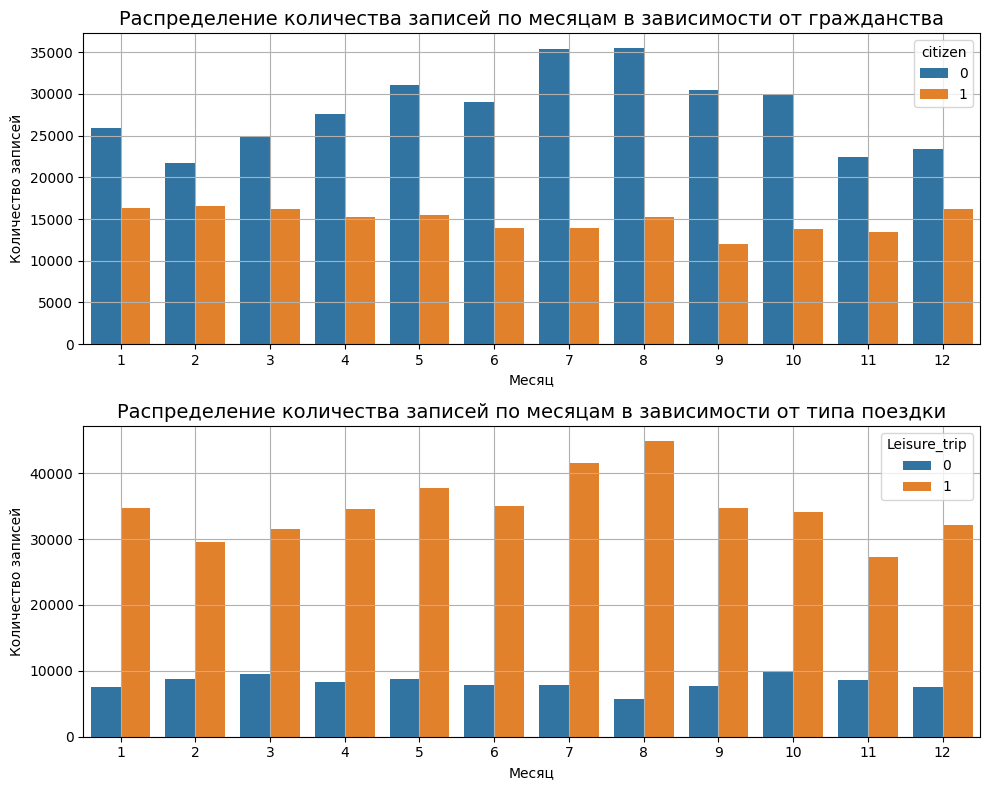

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
sns.barplot(data=data4,
    x='month_rew', 
    y='count', hue='citizen', ax=axes[0])
axes[0].grid()
axes[0].set_title('Распределение количества записей по месяцам в зависимости от гражданства', fontsize=14)
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Количество записей');
sns.barplot(data=data8,
    x='month_rew', 
    y='count', hue='Leisure_trip', ax=axes[1])
axes[1].grid()
axes[1].set_title('Распределение количества записей по месяцам в зависимости от типа поездки', fontsize=14)
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Количество записей')
plt.tight_layout();
fig = axes[0].figure
fig.savefig('pic/pic9.png')
fig = axes[1].figure
fig.savefig('pic/pic10.png')


### Зависимости от месяца более информативны, чем от квартала
### Рассмотрим топ-10 гражданств посетителей по количеству записей

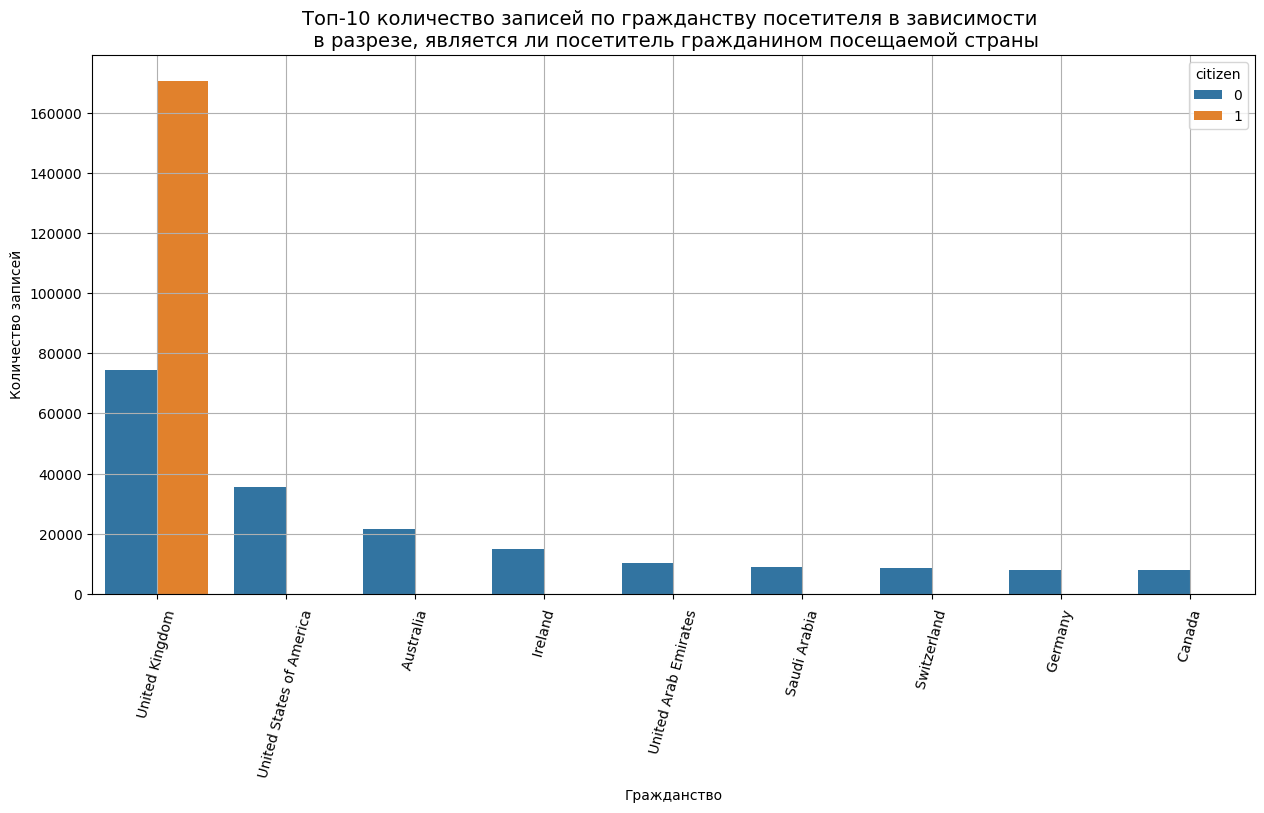

In [31]:
nation = hotels.value_counts(['reviewer_nationality', 'citizen']).reset_index().nlargest(n=10, columns='count')

fig = plt.figure(figsize=(15, 7))
axes = sns.barplot(data=nation,
    x='reviewer_nationality', 
    y='count',
    hue='citizen')
axes.grid()
axes.xaxis.set_tick_params(rotation=75)
axes.set_title('Топ-10 количество записей по гражданству посетителя в зависимости \n в разрезе, является ли посетитель гражданином посещаемой страны', fontsize=14)
axes.set_xlabel('Гражданство')
axes.set_ylabel('Количество записей');
fig = axes.figure
fig.savefig('pic/pic11.png')

### Наблюдается неоднородность данных - большая часть записей принадлежит подданым UK
### Для анализа создадим вспомогательный признак - тип поездки

In [13]:
def get_type_trip(elem):
    list_tag = elem[3: -3].lower().split(" ', ' ")    
    if 'leisure trip' in list_tag: return 'leisure trip'
    elif 'business trip' in list_tag: return 'business trip'
    else: return 'other'

### Посмотрим на распределение записей по типу поездки

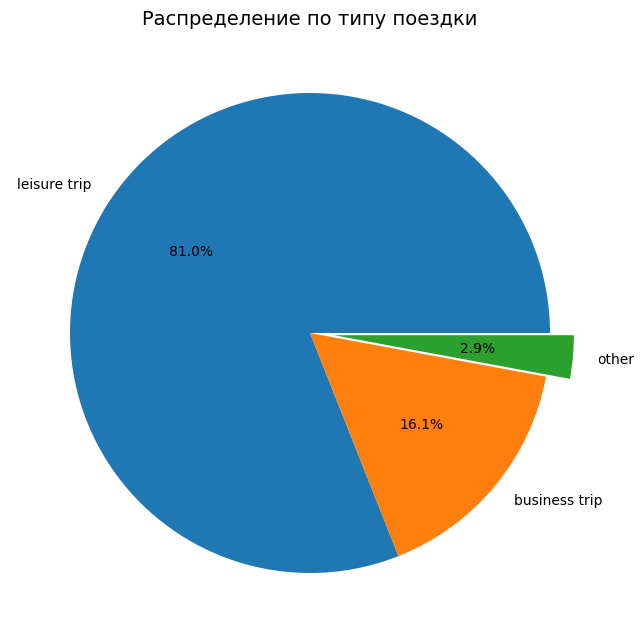

In [14]:
type_trip = hotels['tags'].apply(get_type_trip).value_counts()
fig = plt.figure(figsize=(6, 6))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    type_trip,
    labels=type_trip.index,
    autopct='%.1f%%',
    explode = [0, 0, 0.1]
)
axes.set_title('Распределение по типу поездки', fontsize=14);
fig = axes.figure
fig.savefig('pic/pic12.png')

## 4.7 Выводы
1. Представленные данные неоднородны: наибольшее количество посетителей - подданные UK; наибольшее количество отелей находится в Париже, а наибольшее количество записей приходится на отели Лондона
2. Большинство посетителей отелей Лондона - подданные UK, для остальных стран - имеется обратная тенденция - большинство посетителей - иностранцы
3. Распределения в зависимости от месяца более информативны, чем в зависимости от квартала - признак квартала можно убрать
4. Разбор тегов вносит ряд особенностей. Например, 2.9 % записей либо имеют тип поездки отличный от туристической или деловой, либо это пропуски. Т.е. разбирая теги, помимо информации мы вносим и пропуски.

In [34]:
hotels = hotels.drop(['quarter_rew', 'year_rew'], axis=1)

# 5 Работа с отзывами
## 5.1 На основе отзывов посетителй создадим два новых признака - No_Negative и No_Positive

In [35]:
def get_no_negative(elem):    
    if elem.lower().strip() == 'no negative':
        return 1
    else: return 0

def get_no_positive(elem):    
    if elem.lower().strip() == 'no positive':
        return 1
    else: return 0

In [36]:
hotels['No_Negative'] = hotels['negative_review'].apply(get_no_negative)
hotels['No_Positive'] = hotels['positive_review'].apply(get_no_positive)

## 5.2 Проведем анализ отзывов посетителей с помощью SentimentIntensityAnalyzer

In [37]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

# Создадим функцию для выделения "негатива" из отзыва
def get_neg_from_rew(elem):
    unit = elem.strip()
    rev = sent_analyzer.polarity_scores(unit)
    if unit == 'No Negative' or unit == 'No Positive': return 0
    else: return rev['neg']
        
# Создадим функцию для выделения "позитива" из отзыва
def get_pos_from_rew(elem):
    unit = elem.strip()
    rev = sent_analyzer.polarity_scores(unit)
    if unit == 'No Negative' or unit == 'No Positive': return 0
    else: return rev['pos']
        
# Создадим функцию для выделения "нейтральности" из отзыва
def get_neu_from_rew(elem):
    unit = elem.strip()
    rev = sent_analyzer.polarity_scores(unit)
    if unit == 'No Negative' or unit == 'No Positive': return 0
    else: return rev['neu']
        
# Создадим функцию для выделения 'compound' из отзыва
def get_compound_from_rew(elem):
    unit = elem.strip()
    rev = sent_analyzer.polarity_scores(unit)
    if unit == 'No Negative' or unit == 'No Positive': return 0
    else: return rev['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Kurumir\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:
# Выявим негатив из отзывов
hotels['neg_rew_from_neg'] = hotels['negative_review'].apply(get_neg_from_rew)
hotels['neg_rew_from_pos'] = hotels['positive_review'].apply(get_neg_from_rew)
# Выявим позитив из отзывов
hotels['pos_rew_from_neg'] = hotels['negative_review'].apply(get_pos_from_rew)
hotels['pos_rew_from_pos'] = hotels['positive_review'].apply(get_pos_from_rew)
# Выявим нейтральность из отзывов
hotels['neu_rew_from_neg'] = hotels['negative_review'].apply(get_neu_from_rew)
hotels['neu_rew_from_pos'] = hotels['positive_review'].apply(get_neu_from_rew)
# Определим "compound" отзыва
hotels['compound_from_neg'] = hotels['negative_review'].apply(get_compound_from_rew)
hotels['compound_from_pos'] = hotels['positive_review'].apply(get_compound_from_rew)

# 6 Кодировка признаков
### Закодируем признак национальности посетителя

In [39]:
import category_encoders as ce

In [40]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin1 = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin1], axis=1)

# 7 Нормирование числовых признаков

In [41]:
from sklearn import preprocessing

In [42]:
col_num = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

r_scaler = preprocessing.RobustScaler()

df_r = r_scaler.fit_transform(hotels[col_num])

df_r = pd.DataFrame(df_r, columns=col_num)
df_r.head()

,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
0,0.488798,-0.285714,-0.057096,-0.411765,0.571429
1,-0.085540,-0.285714,-0.315253,-0.529412,1.571429
2,-0.629328,-0.142857,-0.704731,-0.647059,1.571429
3,-0.625255,-0.428571,-0.622757,0.000000,0.714286
4,1.167006,-0.238095,2.223491,0.529412,1.000000


In [43]:
hotels[col_num] = df_r[col_num]

# 8 Анализ признаков
### Выделим все признаки для обучения

In [44]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels1 = hotels.drop(object_columns, axis = 1)

### Разделим признаки на численные и категориальные

In [45]:
num_fear = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'average_score', 'days_since_review', 'lat', 'lng', 'reviewer_score']
full_fear = list(hotels1.columns)
cat_fear = list(set(full_fear) - set(num_fear))
cat_fear.append('reviewer_score')

## 8.1 Корреляция признаков

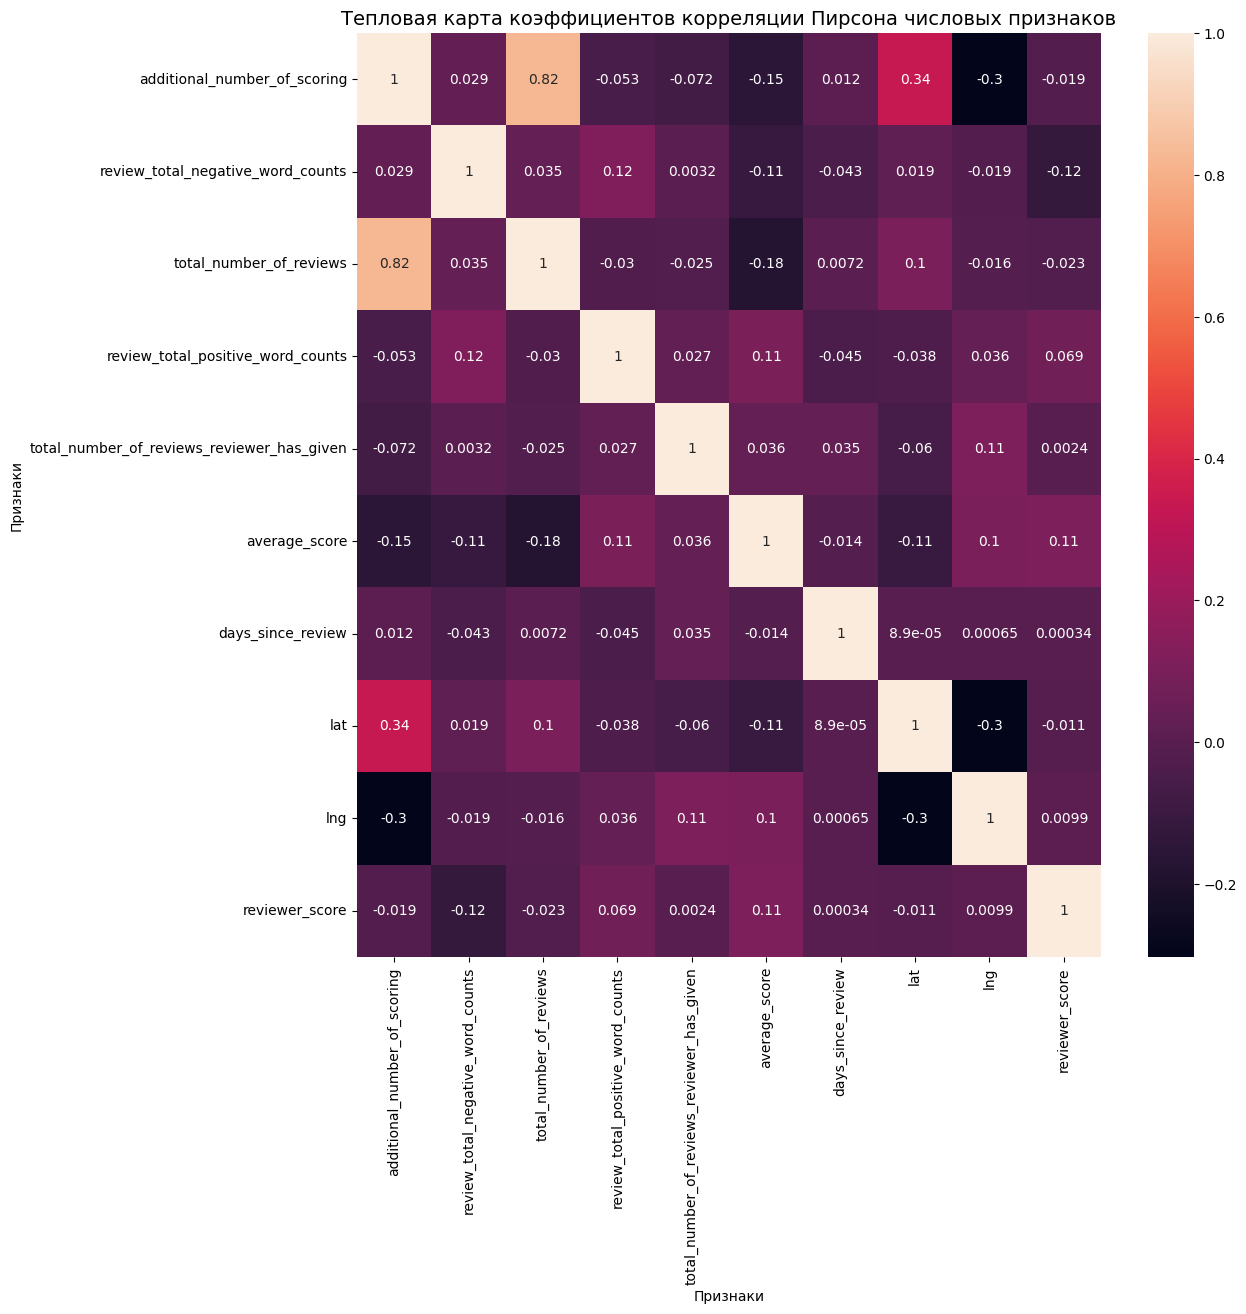

In [46]:
fig= plt.figure(figsize=(12, 12))
ax = sns.heatmap(hotels1[num_fear].corr(), annot=True)
ax.set_title('Тепловая карта коэффициентов корреляции Пирсона числовых признаков', fontsize=14)
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки');
fig = ax.figure
fig.savefig('pic/pic13.png')

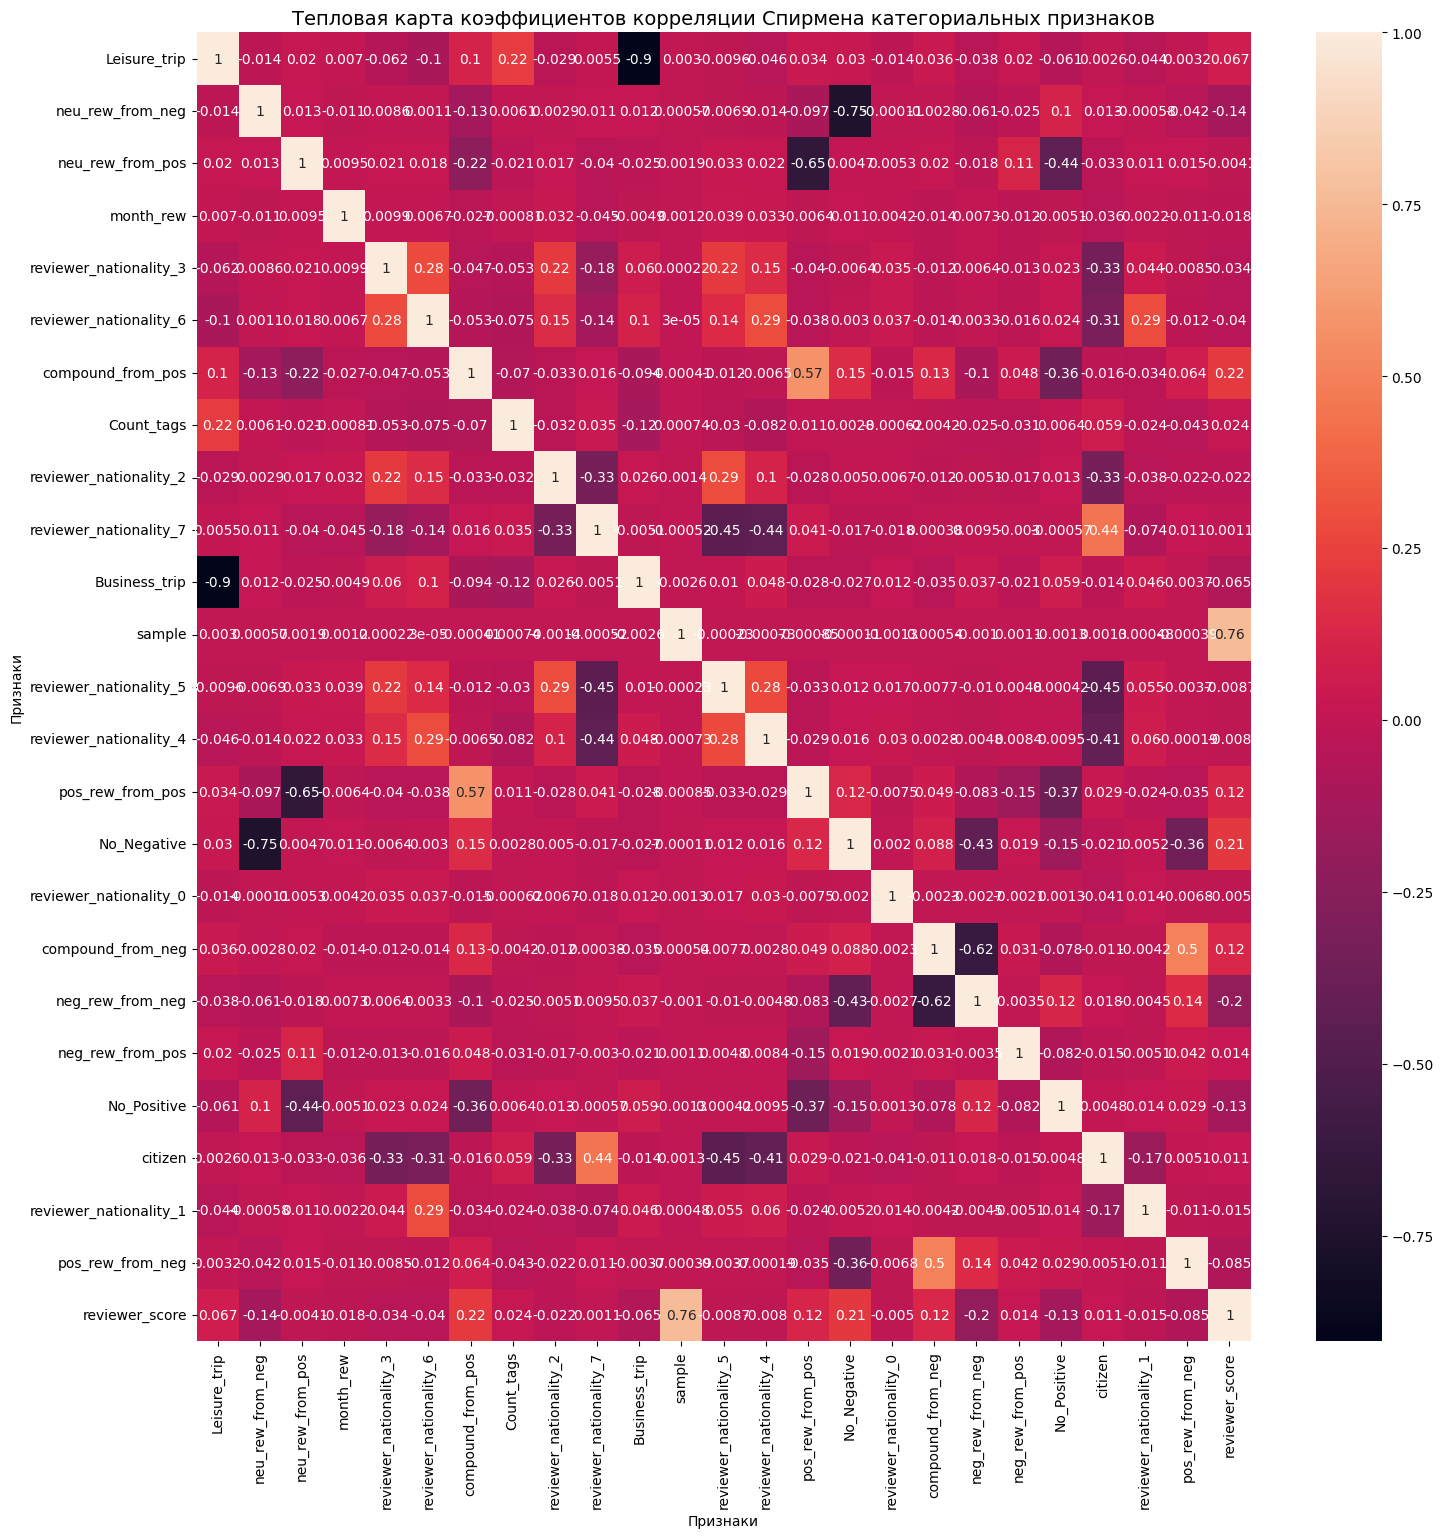

In [47]:
fig = plt.figure(figsize=(17, 17))
ax = sns.heatmap(hotels1[cat_fear].corr(method='spearman'), annot=True)
ax.set_title('Тепловая карта коэффициентов корреляции Спирмена категориальных признаков', fontsize=14)
ax.set_xlabel('Признаки')
ax.set_ylabel('Признаки');
fig = ax.figure
fig.savefig('pic/pic14.png')

## 8.2 Выводы
1. Из численных признаков только признаки 'total_number_of_reviews' и 'additional_number_of_scoring' имеют сильную связь
2. Из категориальных признаков самая сильная корреляция наблюдается между признаками 'Leisure_trip' и 'Business_trip' - как показала практика оставим оба
3. Также сильная корреляция наблюдается между 'neu_rew_from_neg' и 'No_Negative' - тоже оставляем

# 9 Обучение модели

In [48]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels1.drop(['reviewer_score', 'sample'], axis = 1)  
y = hotels1['reviewer_score'] 

### Рассмотрим влияние признаков на целевой признак

In [49]:
col_list = list(X.columns)
y_gr=y.astype('int')

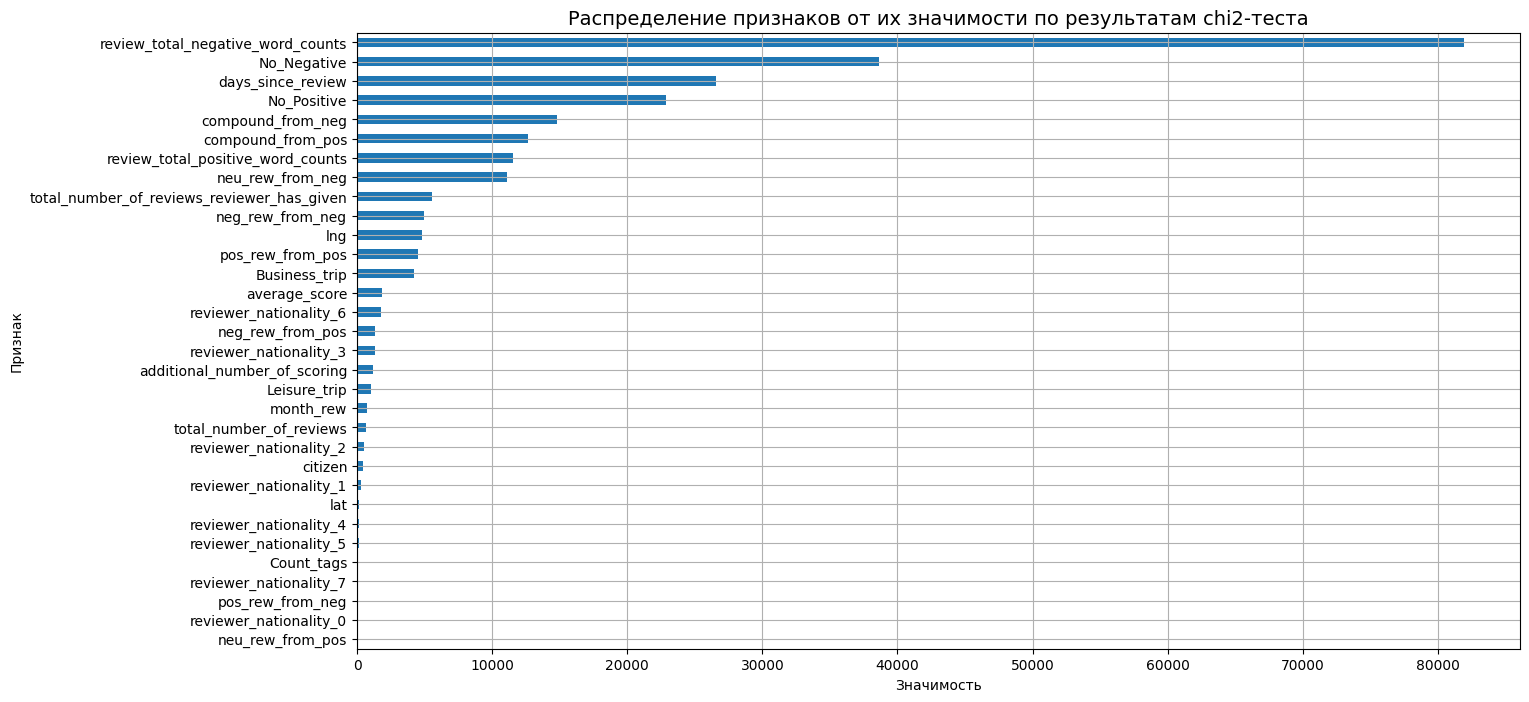

In [50]:
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[col_list].abs(), y_gr)[0], index=col_list)
imp_cat.sort_values(inplace = True)
fig = plt.figure(figsize=(15,8))
ax = imp_cat.plot(kind = 'barh')
ax.grid()
ax.set_title('Распределение признаков от их значимости по результатам chi2-теста', fontsize=14)
ax.set_xlabel('Значимость')
ax.set_ylabel('Признак');
fig = ax.figure
fig.savefig('pic/pic15.png')

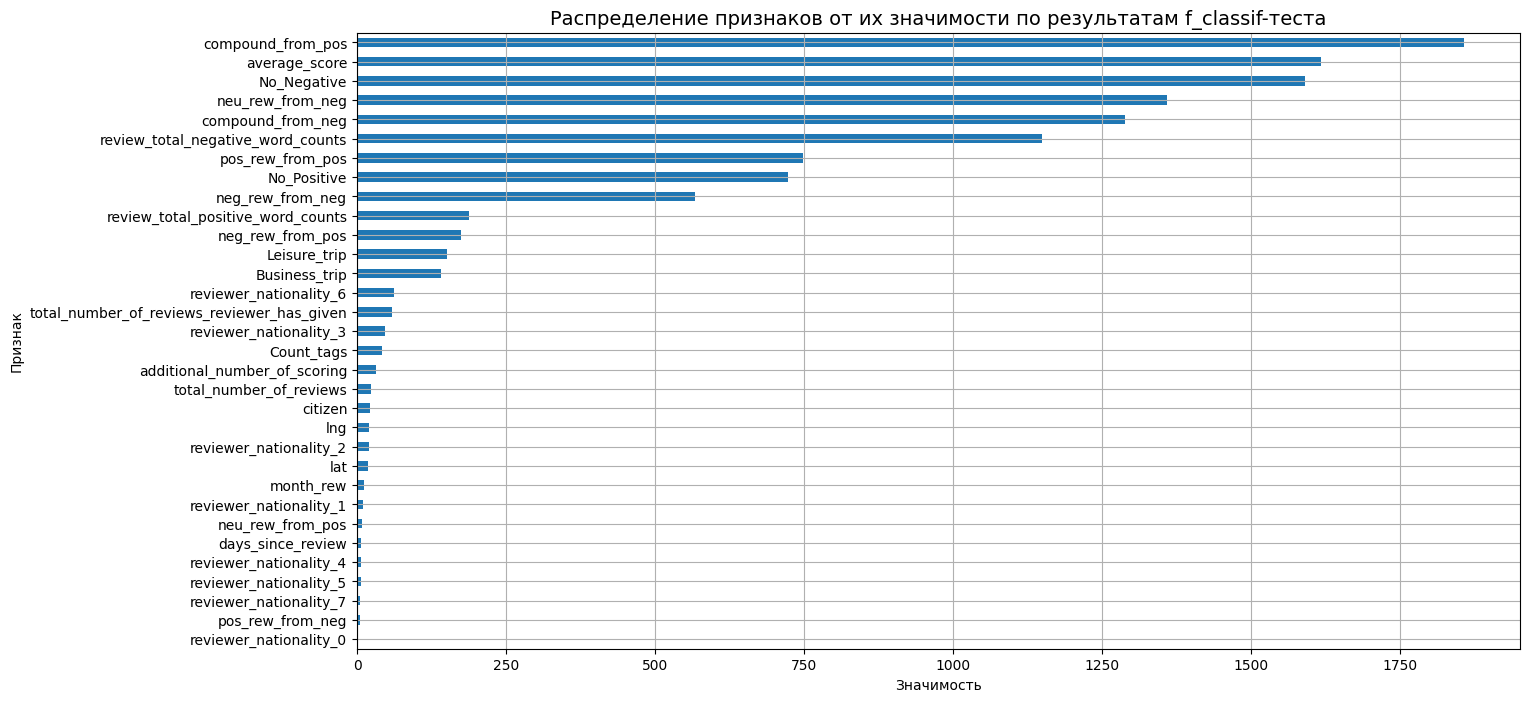

In [51]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[col_list].abs(), y)[0], index = col_list)
imp_num.sort_values(inplace = True)
fig = plt.figure(figsize=(15,8))
ax = imp_num.plot(kind = 'barh', figsize=(15,8))
ax.grid()
ax.set_title('Распределение признаков от их значимости по результатам f_classif-теста', fontsize=14)
ax.set_xlabel('Значимость')
ax.set_ylabel('Признак');
fig = ax.figure
fig.savefig('pic/pic16.png')

### Согласно Хи-квадрат наиболее важные признаки - 'review_total_negative_word_counts', 'No_Negative' и 'days_since_review'
### Согласно f_classif - 'compound_from_pos', No_Negative' и 'average_score'

In [52]:
# Теперь выделим тестовую часть
train_data = hotels1.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels1.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [54]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [55]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 33), (386803, 33), (386803, 32), (309442, 32), (77361, 32))

In [56]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

In [57]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.8s finished


In [59]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred) * 100)

MAPE: 12.524147454930173


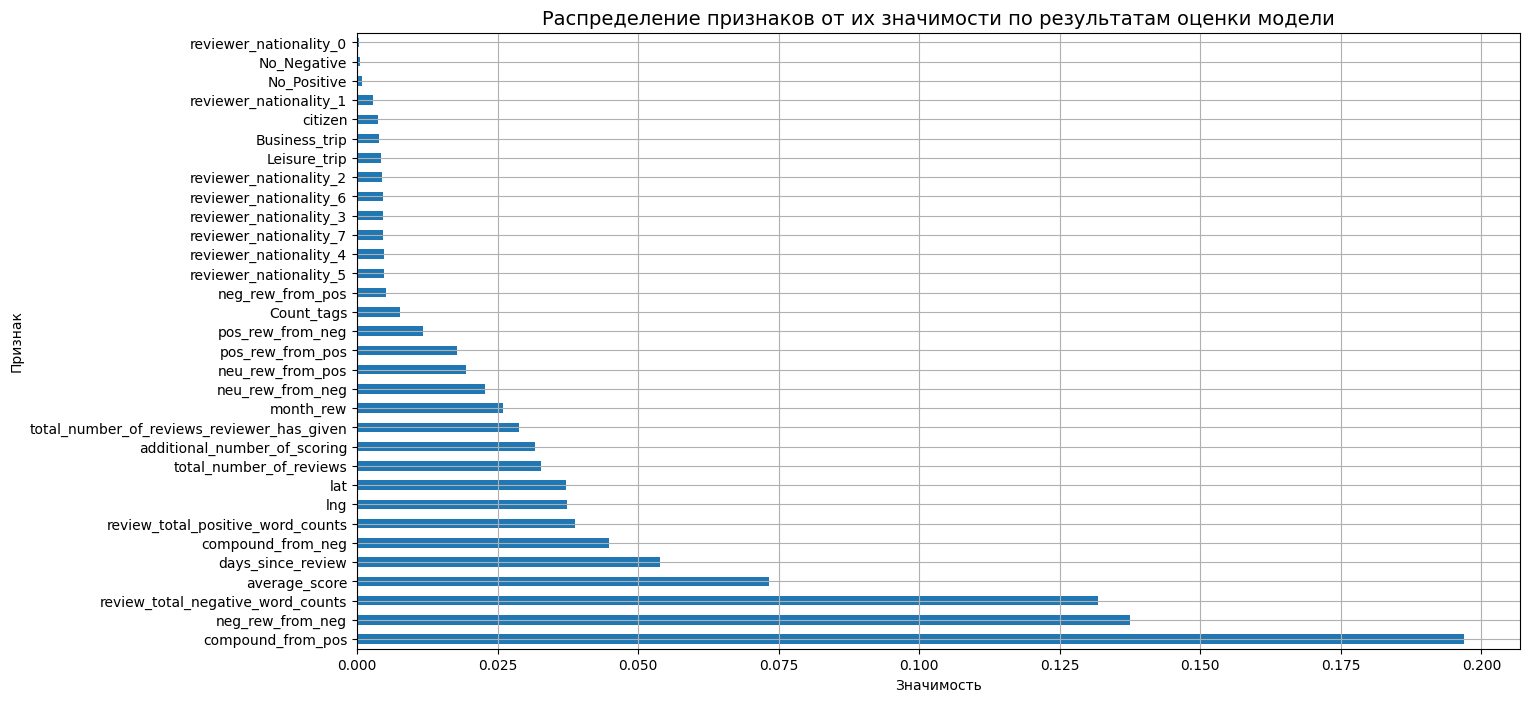

In [60]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

fig = plt.figure(figsize=(15,8))
ax = feat_importances.nlargest(X.shape[1]).plot(kind='barh')
ax.grid()
ax.set_title('Распределение признаков от их значимости по результатам оценки модели', fontsize=14)
ax.set_xlabel('Значимость')
ax.set_ylabel('Признак');
fig = ax.figure
fig.savefig('pic/pic17.png')

### Согласно модели наиболее важные признаки - признаки полученные при анализе отзывов посетителя. Наиболее близкие по значимости данные давал тест f_classif

In [61]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,...,compound_from_neg,compound_from_pos,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,reviewer_nationality_5,reviewer_nationality_6,reviewer_nationality_7
449987,0.568228,9.0,0.095238,-0.065253,0.176471,2.000000,0.0,408,51.506558,-0.004514,...,0.0000,0.7269,0,0,0,0,0,0,0,1
408718,0.266802,8.0,-0.428571,-0.308320,-0.294118,0.000000,0.0,399,51.470360,-0.177987,...,0.0000,0.8271,0,0,0,0,0,0,0,1
423139,0.389002,8.6,0.904762,0.873573,1.647059,0.285714,0.0,359,41.385639,2.166827,...,-0.2960,0.7645,0,0,0,1,0,1,1,0
508567,0.568228,9.0,0.428571,-0.065253,0.000000,0.142857,0.0,235,51.506558,-0.004514,...,-0.3412,0.7269,0,0,0,0,0,0,0,1
405841,0.529532,8.5,-0.285714,0.774062,2.352941,0.285714,0.0,557,52.363889,4.881302,...,-0.2960,0.8396,0,0,0,0,0,0,1,0
432802,1.240326,8.6,-0.238095,0.551387,-0.235294,-0.285714,0.0,386,51.506472,-0.071689,...,0.2924,0.5859,0,0,0,0,0,0,0,1
445309,0.138493,8.3,-0.333333,-0.221044,0.882353,3.714286,0.0,630,51.506935,-0.126012,...,0.0000,0.8689,0,0,1,0,0,1,0,0
486620,-0.238289,8.6,0.523810,0.088499,0.470588,1.857143,0.0,229,45.484137,9.200162,...,0.4767,0.6249,0,0,0,1,0,0,1,1
486714,-0.529532,7.5,-0.095238,-0.565661,-0.470588,0.285714,0.0,334,41.403797,2.213767,...,0.0000,0.4404,0,0,1,0,0,0,0,1
495460,2.246436,7.8,-0.190476,1.464927,-0.058824,-0.142857,0.0,322,51.493508,-0.183435,...,0.0000,0.7506,0,0,0,1,1,0,1,0


In [62]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [63]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [64]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


In [65]:
predict_submission

array([8.573, 7.531, 8.458, ..., 8.052, 9.696, 7.126], shape=(128935,))

In [66]:
list(sample_submission)

['reviewer_score', 'id']

In [67]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.573,488440
1,7.531,274649
2,8.458,374688
3,9.738,404352
4,9.465,451596
5,8.928,302161
6,7.231,317079
7,7.029,13963
8,8.279,159785
9,7.588,195089


# 10 Результаты
### Согластно Т.З. необходимо создать модель для предсказания рейтинга отеля. Нам предоставили данные с отзывами посетителей отелей. Данные были обработаны - очищенны, были созданы новые признаки. На основании обработанных данных была обучена модель, показывающая на тестовой выборка точность MAPE = 12.5 %, что достаточно для заказчика.

# 11 Выводы
* Нам были переданы данные с оценкой отеля посетителя и по ним обучена модель предсказывающая по данным посетителя его еценку - что не соответствует Т.З. - необходимо предсказать рейтинг отеля. Рейтинг конечно тоже зависит от оценки посетителя, но уж точно не одного. Полученную модель можно использовать, например, для востановления оценки посетителя.
* Переданные данные очень неоднородны (наибольшее количество отзывов относится к посетителям из UK и к отелям Лондона) при этом все записи описывают только отели в 6 городах в 6 разных странах.
* Наибольшее влияние на качество модели оказывает анализ отзывов посетителей.
* Работа с тегами вместе с новыми признаками добавляет и пропуски в этих признаках.
* Предположительно, улучшить качество модели можно, проведя более детальный анализ отзывов и тегов